In [1]:
import gym
import gym_anytrading

from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('data/BTCUSDT-5m-data.csv').iloc[:, :6]

In [12]:
df['Timestamp'] = pd.to_datetime(df.Timestamp)

In [15]:
df.set_index('Timestamp', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666
2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570


In [41]:
env = gym.make('stocks-v0',
               df=df,
               frame_bound=(1, 100), # data you want to include
               window_size=1) # determine window to view the data

info {'total_reward': -41.659999999999854, 'total_profit': 0.7219331990182459, 'position': 0}


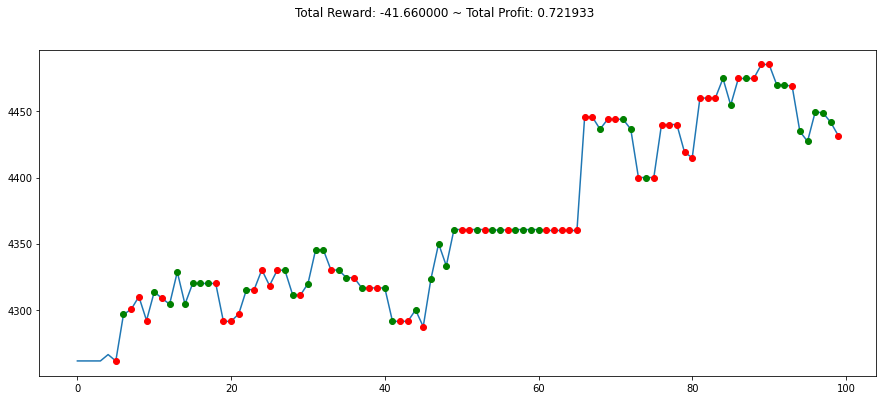

In [38]:
state = env.reset()
while True:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done:
        print('info', info)
        break
plt.figure(figsize=(15, 6))
plt.cla()
env.render_all()
plt.show()

In [39]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5, 100), window_size=5)
env = DummyVecEnv([env_maker])

In [ ]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=100000)